## Objetivo:

O objetivo desta competição é desenvolver um modelo preditor do ELDT (Estimated Landing Time) para voos comerciais com origem e 
destino nos 12 principais aeródromos do Brasil, a saber:

- Brasília (SBBR)
- Confins (SBCF)
- Curitiba (SBCT)
- Florianópolis (SBFL)
- Rio de Janeiro - Galeão (SBGL)
- Guarulhos (SBGR)
- Campinas (SBKP)
- Porto Alegre (SBPA)
- Recife (SBRF)
- Rio de Janeiro - Santos Dumont (SBRJ)
- São Paulo - Congonhas (SBSP)
- Salvador (SBSV)

In [ ]:
!pip install xgboost
!pip install geopy

import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xg
import requests
from geopy.distance import geodesic as GD
import pickle as pk
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

random.seed(1)

print(f'tf_version: {tf.__version__}')


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
2023-09-22 03:54:10.757872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 03:54:10.907327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-22 03:54:10.907353: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-22 03:54:10.955244: E tensor

In [ ]:
# Carregar o dataset BIMTRA

idate = '2023-01-01'
fdate = '2023-01-09'

url = 'http://montreal.icea.decea.mil.br:5002/api/v1/bimtra'
params = {
    'token': 'a779d04f85c4bf6cfa586d30aaec57c44e9b7173',
    'idate': idate,
    'fdate': fdate
}

headers = {'accept': 'application/json'}

response = requests.get(url, params=params, headers=headers)

if response.status_code == 200:
    BIMTRA_json = response.json()
    BIMTRA_df = pd.DataFrame(BIMTRA_json)
    print("BIMTRA carregado com sucesso!")
else:
    print(f"A solicitação falhou com status code {response.status_code}")

BIMTRA carregado com sucesso!


In [ ]:
# Converter "dt_dep" e "dt_arr" para objetos de data e hora
BIMTRA_df['dt_dep'] = pd.to_datetime(BIMTRA_df['dt_dep'], unit='ms')
BIMTRA_df['dt_arr'] = pd.to_datetime(BIMTRA_df['dt_arr'], unit='ms')
BIMTRA_df

,flightid,origem,destino,dt_dep,dt_arr
0,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,2023-01-01 01:29:51,2023-01-01 02:27:17
1,77146493eed6e8bd3b2c6bf664ab6463,SBGR,SBRF,2023-01-01 20:27:38,2023-01-01 23:05:10
2,f31820131a516c1ec5ee15f83069e85b,SBSV,SBGR,2023-01-01 14:33:48,2023-01-01 16:46:42
3,764519556a57671a468ddc3ca88bd53c,SBRF,SBRJ,2023-01-01 16:33:22,2023-01-01 19:35:39
4,9eb9087ec842a67d6269411ba200200c,SBPA,SBRJ,2023-01-01 19:32:09,2023-01-01 21:23:14
...,...,...,...,...,...
7426,d3119f952b9f14ccbf6ad1c09a488ea8,SBCT,SBGR,2023-01-01 02:24:26,2023-01-01 03:01:41
7427,4a4f48e2f236b5849724f1ca554aec9e,SBCT,SBGR,2023-01-01 12:08:47,2023-01-01 12:44:43
7428,8b8c934cda4bca3f1459850a85b80ce6,SBCF,SBGR,2023-01-01 20:15:18,2023-01-01 21:10:52
7429,abe3dd7a006dab7efcf419bd38521a0a,SBCF,SBGR,2023-01-01 22:53:03,2023-01-01 23:58:15


In [ ]:
# Carrega arquivo com lista de requests
CAT_df = pk.load(open('CAT-2023-01-01-2023-01-09.pk', 'rb'))

# Arrays contendo os horários de decolagem numa janela de 2 minuto
dt_dep_i = BIMTRA_df['dt_dep'] - datetime.timedelta(minutes=10)
dt_dep_f = BIMTRA_df['dt_dep'] + datetime.timedelta(minutes=10)

# Para melhorar o intervalo de busca, é preciso zerar os segundos
for i, dt in enumerate(dt_dep_i):
    dt_dep_i[i] = str(dt)[:-2] + '00' # Zera últimos 2 digitos (segundos)
    
for i,dt in enumerate(dt_dep_f):
    dt_dep_f[i] = str(dt)[:-2] + '00' # Zera últimos 2 digitos (segundos)

# Converte 'dt_radar' para datetime
dt_radar = CAT_df['dt_radar']
CAT_df['dt_radar'] = pd.to_datetime(CAT_df['dt_radar'], unit='ms')

CAT_list = [] # Lista de pontos do radar para cada voo do BIMTRA
coord_list = [] # Lista de pontos proximos para cada voo do BIMTRA

# Precisamos buscar todos os pontos de radar no horário de decolagem de cada voo
for i in dt_dep_i.index: # Para cada linha no BIMTRA
    # Busca todos os pontos de radar dentro de 1 minuto da hora de decolagem
    mask = (CAT_df['dt_radar'] >= dt_dep_i[i]) & (CAT_df['dt_radar'] <= dt_dep_f[i])
    # CAT_list(-1).merge(BIMTRA_df[''])
    CAT_list.append(CAT_df[mask])
    CAT_list[i].drop_duplicates(inplace=True, subset='flightid')
    coord_list.append((CAT_list[i]['lat'].to_numpy(dtype=float), CAT_list[i]['lon'].to_numpy(dtype=float)))

# Ajusta a lista para coordenadas no formato (np.array,np.array)
for i, coord in enumerate(coord_list):
    coord_list[i] = np.degrees(np.vstack([coord[0],coord[1]]).transpose())

display(CAT_list[6])
print(coord_list[6])

/tmp/ipykernel_1291/279667918.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CAT_list[i].drop_duplicates(inplace=True, subset='flightid')


,flightid,lat,lon,flightlevel,speed,dt_radar
42715,e79410382c282a0e87e9d5d74c3f7d0b,-0.403899,-0.805472,139.0,348.0,2023-01-01 11:39:02
118167,d3b5df165fd311b137760db1e6c02352,-0.366796,-0.783539,350.0,524.0,2023-01-01 11:46:04
148234,f9a542179b8b864e3a3f45ce0e05ab05,-0.360257,-0.772507,390.0,505.0,2023-01-01 11:27:05
184314,0eecdf243975b09ac5248fed0d606ef0,-0.433562,-0.837963,380.0,382.0,2023-01-01 11:38:05
197865,39ca4cd1f46e6534e3d04f7f26cff13c,-0.343041,-0.767038,34.0,166.0,2023-01-01 11:44:03
212456,1daa429120a26886060398c726920cb8,-0.154936,-0.619268,225.0,403.0,2023-01-01 11:33:00
216849,56995ecc6daaa723746cdd1f3bbca984,-0.406646,-0.815733,149.0,339.0,2023-01-01 11:39:02
233163,b219b154298600897794e910ad450a4e,-0.414422,-0.813174,256.0,363.0,2023-01-01 11:38:01
249274,3ed9be1ff065175acf551e9af2a8aa19,-0.353055,-0.827810,380.0,473.0,2023-01-01 11:37:01
260194,05e48e0e9bedca4016d35bb11a0d8efd,-0.395429,-0.809441,243.0,413.0,2023-01-01 11:47:00


[[-23.14169146 -46.15016296]
 [-21.01585978 -44.89349122]
 [-20.64119821 -44.26140719]
 [-24.84129957 -48.01176809]
 [-19.65480497 -43.94803414]
 [ -8.87719176 -35.48143594]
 [-23.29910248 -46.73804779]
 [-23.74462487 -46.59141725]
 [-20.22858952 -47.429993  ]
 [-22.65639671 -46.37757606]
 [-19.65646799 -43.94738525]
 [-23.28030734 -47.00487884]
 [-25.53375236 -49.16893187]
 [-24.93402205 -48.17339125]
 [-28.20906877 -49.94966481]
 [-21.21013885 -45.02360256]
 [-16.52518498 -47.36283017]
 [-17.10572915 -47.05302598]
 [-15.1571298  -46.64175351]
 [-23.47241801 -44.39318172]
 [-22.92844137 -43.46409699]
 [-18.03042523 -46.69317922]
 [-15.87744748 -47.91021102]
 [-20.05647089 -44.68612861]
 [-29.99068879 -51.16581208]
 [-13.92412287 -39.30803037]]


In [ ]:
# Dicionário contendo as coordenadas de todos os aeródromos
coord_aerodromos={
    'SBBR': [-15.87094, -47.91962],
    'SBCF': [-19.63372, -43.96416],
    'SBCT': [-25.53262, -49.17355],
    'SBFL': [-27.67377, -48.54672], 
    'SBGL': [-22.80559, -43.25698],
    'SBGR': [-23.42812, -46.46996],
    'SBKP': [-23.00850, -47.14706],
    'SBPA': [-29.99615, -51.17717],
    'SBRF': [-8.132756, -34.91726],
    'SBRJ': [-22.91121, -43.16718],
    'SBSP': [-23.62837, -46.65696],
    'SBSV': [-12.91205, -38.32935],
}

raio = 500 # Raio em km para contagem de aeronaves
coords_raio = []
# Cria a lista coords_raio, contendo todos as coordenadas dentro de um raio para cada decolagem
for i, coords in enumerate(coord_list):
    aerodromo = BIMTRA_df['origem'][i] # Aerodromo de origem
    coords_aerodromo = coord_aerodromos[aerodromo] # Coordenadas do aerodromo de origem
    _temp = []
    for pair in coords:
        _distance = GD(coords_aerodromo,pair).km # Calcula a distância em km
        if _distance <= raio:
            _temp.append(pair)
    coords_raio.append(np.array(_temp))

# Cria uma lista com o número de aeronaves para cada linha do BIMTRA
n_aeronaves = [i.shape[0] - 1 for i in coords_raio] # Remove 1, pois é a própria aeronave decolando
n_aeronaves_total = [len(i) for i in CAT_list]

BIMTRA_df['n_aeronaves_500km'] = n_aeronaves
BIMTRA_df['n_aeronaves_total'] = n_aeronaves_total
display(BIMTRA_df)

,flightid,origem,destino,dt_dep,dt_arr,n_aeronaves_500km,n_aeronaves_total
0,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,2023-01-01 01:29:51,2023-01-01 02:27:17,3,20
1,77146493eed6e8bd3b2c6bf664ab6463,SBGR,SBRF,2023-01-01 20:27:38,2023-01-01 23:05:10,44,75
2,f31820131a516c1ec5ee15f83069e85b,SBSV,SBGR,2023-01-01 14:33:48,2023-01-01 16:46:42,6,50
3,764519556a57671a468ddc3ca88bd53c,SBRF,SBRJ,2023-01-01 16:33:22,2023-01-01 19:35:39,5,67
4,9eb9087ec842a67d6269411ba200200c,SBPA,SBRJ,2023-01-01 19:32:09,2023-01-01 21:23:14,8,76
...,...,...,...,...,...,...,...
7426,d3119f952b9f14ccbf6ad1c09a488ea8,SBCT,SBGR,2023-01-01 02:24:26,2023-01-01 03:01:41,8,20
7427,4a4f48e2f236b5849724f1ca554aec9e,SBCT,SBGR,2023-01-01 12:08:47,2023-01-01 12:44:43,13,43
7428,8b8c934cda4bca3f1459850a85b80ce6,SBCF,SBGR,2023-01-01 20:15:18,2023-01-01 21:10:52,32,72
7429,abe3dd7a006dab7efcf419bd38521a0a,SBCF,SBGR,2023-01-01 22:53:03,2023-01-01 23:58:15,36,71


In [ ]:
# Converte para tempo inteiro
BIMTRA_df['dt_dep'] = pd.to_datetime(BIMTRA_df['dt_dep'], format='%Y-%m-%d %H:%M:%S.%f')
BIMTRA_df['dt_dep'] = (BIMTRA_df['dt_dep'].astype(int) / 10**6) #.astype('datetime64[ms]')
BIMTRA_df['dt_arr'] = pd.to_datetime(BIMTRA_df['dt_arr'], format='%Y-%m-%d %H:%M:%S.%f')
BIMTRA_df['dt_arr'] = (BIMTRA_df['dt_arr'].astype(int) / 10**6) #.astype('datetime64[ms]')

# Cálculo do ELDT 
ELDT = BIMTRA_df['dt_arr'] - BIMTRA_df['dt_dep']
BIMTRA_df['eldt'] = ELDT
BIMTRA_df.drop('dt_arr', axis=1, inplace=True)
BIMTRA_df

,flightid,origem,destino,dt_dep,n_aeronaves_500km,n_aeronaves_total,eldt
0,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1.672537e+12,3,20,3446000.0
1,77146493eed6e8bd3b2c6bf664ab6463,SBGR,SBRF,1.672605e+12,44,75,9452000.0
2,f31820131a516c1ec5ee15f83069e85b,SBSV,SBGR,1.672584e+12,6,50,7974000.0
3,764519556a57671a468ddc3ca88bd53c,SBRF,SBRJ,1.672591e+12,5,67,10937000.0
4,9eb9087ec842a67d6269411ba200200c,SBPA,SBRJ,1.672602e+12,8,76,6665000.0
...,...,...,...,...,...,...,...
7426,d3119f952b9f14ccbf6ad1c09a488ea8,SBCT,SBGR,1.672540e+12,8,20,2235000.0
7427,4a4f48e2f236b5849724f1ca554aec9e,SBCT,SBGR,1.672575e+12,13,43,2156000.0
7428,8b8c934cda4bca3f1459850a85b80ce6,SBCF,SBGR,1.672604e+12,32,72,3334000.0
7429,abe3dd7a006dab7efcf419bd38521a0a,SBCF,SBGR,1.672614e+12,36,71,3912000.0


In [ ]:
# Função para carregar os dados da API

def get_data_from_API(base_name, idate, fdate, token='a779d04f85c4bf6cfa586d30aaec57c44e9b7173'):
    ''' base_name (string): nome da base, opcões: bimtra, cat-62, esperas, metaf, metar, satelite, tc-prev, tc-real
        idate (string): data inicial
        fdate (string): data final
        token (string): chave de acesso na API já está defaltada
    ''' 


    url = 'http://montreal.icea.decea.mil.br:5002/api/v1/' + base_name
    params = {
    'token': token,
    'idate': idate,
    'fdate': fdate
}

    headers = {'accept': 'application/json'}

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        base = response.json()
        print(f"Base {base_name} carregada com sucesso!")
        return pd.DataFrame(base)
    else:
        print(f"A solicitação falhou com status code {response.status_code}")

In [ ]:
# Função para transformar datetime em int64

def datetime_to_int64(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S.%f')
    df[column] = (df[column].astype(int) / 10**6) #.astype('datetime64[ms]')
    return df

# Função para transformar int64 em datetime

def int64_to_datetime(data, column=None):
    if column is None:
        # Se 'column' não for especificado, assumimos que 'data' é uma Series
        return data.astype('datetime64[ms]')
    else:
        # Se 'column' for especificado, assumimos que 'data' é um DataFrame
        data[column] = data[column].astype('datetime64[ms]')
        return data

In [ ]:
BIMTRA_df = pd.DataFrame(BIMTRA_json)
print(BIMTRA_df)
# Converter "dt_dep" e "dt_arr" para objetos de data e hora
# BIMTRA_df['dt_dep'] = pd.to_datetime(BIMTRA_df['dt_dep'], unit='ms')
# BIMTRA_df['dt_arr'] = pd.to_datetime(BIMTRA_df['dt_arr'], unit='ms')

                              flightid origem destino         dt_dep  \
0     8d03bca2ee2d1def11cd7e8c5e5aa0ae   SBBR    SBCF  1672536591000   
1     33ce5d33ca3414163a9a53b8ef481306   SBCF    SBKP  1672532479000   
2     af199802cfa3ca88b4ed914d5d6eeac8   SBRJ    SBSP  1672531827000   
3     a3c9ce921ea79926bd098837cabc0cdd   SBKP    SBPA  1672537722000   
4     c5b616967027478ae772bc85c69d0850   SBGR    SBCF  1672597702000   
...                                ...    ...     ...            ...   
7426  d3119f952b9f14ccbf6ad1c09a488ea8   SBCT    SBGR  1672539866000   
7427  4a4f48e2f236b5849724f1ca554aec9e   SBCT    SBGR  1672574927000   
7428  8b8c934cda4bca3f1459850a85b80ce6   SBCF    SBGR  1672604118000   
7429  abe3dd7a006dab7efcf419bd38521a0a   SBCF    SBGR  1672613583000   
7430  5485c55e0e6acfb7f9d5a0ffed19546b   SBCF    SBRF  1672574743000   

             dt_arr  
0     1672540037000  
1     1672535819000  
2     1672534699000  
3     1672542680000  
4     1672601029000  
...

In [ ]:
display(BIMTRA_df.head())
display(BIMTRA_df.info())

,flightid,origem,destino,dt_dep,dt_arr
0,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000
1,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000
2,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000
3,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000
4,c5b616967027478ae772bc85c69d0850,SBGR,SBCF,1672597702000,1672601029000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7431 entries, 0 to 7430
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   flightid  7431 non-null   object
 1   origem    7431 non-null   object
 2   destino   7431 non-null   object
 3   dt_dep    7431 non-null   int64 
 4   dt_arr    7431 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 290.4+ KB


None

In [ ]:
esperas_df = get_data_from_API('esperas', idate, fdate)
tc_prev_df = get_data_from_API('tc-prev', idate, fdate)
tc_real_df = get_data_from_API('tc-real', idate, fdate)

Base esperas carregada com sucesso!
Base tc-prev carregada com sucesso!
Base tc-real carregada com sucesso!


# 1. Tratamento de Dados

## 1.1 Células vazias e duplicadas

In [ ]:
# Checagem de células vazias
display(pd.DataFrame(BIMTRA_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', BIMTRA_df.duplicated().sum())
BIMTRA_df_adjusted = BIMTRA_df.drop_duplicates(inplace=False)

,Nº Células Vazias
flightid,0
origem,0
destino,0
dt_dep,0
n_aeronaves_500km,0
n_aeronaves_total,0
eldt,0


Número de duplicatas:  71


In [ ]:
print('Número de duplicatas após eliminação: ', BIMTRA_df_adjusted.duplicated().sum())

Número de duplicatas após eliminação:  0


In [ ]:
# Checagem de células vazias
display(pd.DataFrame(tc_prev_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', tc_prev_df.duplicated().sum())
tc_prev_df_adjusted = tc_prev_df.drop_duplicates(inplace=False)

,Nº Células Vazias
hora,0
troca,0
aero,0


Número de duplicatas:  0


In [ ]:
# Checagem de células vazias
display(pd.DataFrame(tc_real_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', tc_real_df.duplicated().sum())
tc_real_df_adjusted = tc_real_df.drop_duplicates(inplace=False)

,Nº Células Vazias
hora,0
nova_cabeceira,0
antiga_cabeceira,0
aero,0


Número de duplicatas:  0


In [ ]:
# Checagem de células vazias
display(pd.DataFrame(esperas_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', esperas_df.duplicated().sum())
esperas_df_adjusted = esperas_df.drop_duplicates(inplace=False)

,Nº Células Vazias
esperas,0
hora,0
aero,0


Número de duplicatas:  0


## 1.2 Valores negativos

In [ ]:
# Máscara booleana das linhas <= 0
mask = BIMTRA_df['eldt'] <= 0

print('Número de linhas onde ELDT <= 0: ', BIMTRA_df[mask].values.shape[0])
display(BIMTRA_df[mask])

# Remove as linhas
BIMTRA_df_adjusted = BIMTRA_df[~mask]

Número de linhas onde ELDT <= 0:  3


,flightid,origem,destino,dt_dep,n_aeronaves_500km,n_aeronaves_total,eldt
1690,e82048177bf7703fd3f22425d9b1084f,SBRJ,SBFL,1.672853e+12,37,77,-4322000.0
3355,2b348d145754b8e9ac4de0469ed300fe,SBGR,SBFL,1.673049e+12,12,18,-72830000.0
6438,2d68d999f28e86f6154abc230129299d,SBSP,SBSV,1.673266e+12,60,97,-3767000.0


## 1.3 Alterar colunas e juntar os dados

Vamos arredondar as horas para baixo numa nova coluna para ser usada como referência quando for juntar dataframes diferentes que precisam se identificar pelas horas. Para tal, utilizamos o método floor passando o "H" de horas como parâmetro.

In [ ]:
hora_ref = BIMTRA_df_adjusted['dt_dep']# Valores em int64 
hora_ref = int64_to_datetime(hora_ref) # Transformando series em datetime
hora_ref = hora_ref.dt.floor('H') # Aproximando horas para baixo
BIMTRA_df_adjusted['hora_ref'] = hora_ref # Adicionando nova coluna

BIMTRA_df_adjusted['hora_ref']

/tmp/ipykernel_1291/36967095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BIMTRA_df_adjusted['hora_ref'] = hora_ref # Adicionando nova coluna


0      2023-01-01 01:00:00
1      2023-01-01 20:00:00
2      2023-01-01 14:00:00
3      2023-01-01 16:00:00
4      2023-01-01 19:00:00
               ...        
7426   2023-01-01 02:00:00
7427   2023-01-01 12:00:00
7428   2023-01-01 20:00:00
7429   2023-01-01 22:00:00
7430   2023-01-01 12:00:00
Name: hora_ref, Length: 7428, dtype: datetime64[ns]

### Esperas

In [ ]:
esperas_df_adjusted.head()

,esperas,hora,aero
0,0,1672531200000,SBBR
1,0,1672534800000,SBBR
2,0,1672538400000,SBBR
3,0,1672542000000,SBBR
4,0,1672545600000,SBBR


In [ ]:
esperas_to_merge = esperas_df_adjusted.copy()

# Data e hora
int64_to_datetime(esperas_to_merge, 'hora')
esperas_to_merge.rename(columns={'hora': 'hora_esperas'}, inplace=True)

esperas_to_merge.rename(columns={'aero': 'destino'}, inplace=True)
esperas_to_merge

,esperas,hora_esperas,destino
0,0,2023-01-01 00:00:00,SBBR
1,0,2023-01-01 01:00:00,SBBR
2,0,2023-01-01 02:00:00,SBBR
3,0,2023-01-01 03:00:00,SBBR
4,0,2023-01-01 04:00:00,SBBR
...,...,...,...
2587,0,2023-01-09 19:00:00,SBSV
2588,0,2023-01-09 20:00:00,SBSV
2589,0,2023-01-09 21:00:00,SBSV
2590,0,2023-01-09 22:00:00,SBSV


In [ ]:
BIMTRA_df_adjusted_to_merge = BIMTRA_df_adjusted.copy()

BIMTRA_df_adjusted_to_merge['hora_esperas'] = BIMTRA_df_adjusted_to_merge['hora_ref'] - pd.Timedelta(hours=1)

BIMTRA_df_adjusted_to_merge = pd.merge(BIMTRA_df_adjusted_to_merge, esperas_to_merge, on=['destino', 'hora_esperas'], how='left')
BIMTRA_df_adjusted_to_merge

,flightid,origem,destino,dt_dep,n_aeronaves_500km,n_aeronaves_total,eldt,hora_ref,hora_esperas,esperas
0,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1.672537e+12,3,20,3446000.0,2023-01-01 01:00:00,2023-01-01 00:00:00,0.0
1,77146493eed6e8bd3b2c6bf664ab6463,SBGR,SBRF,1.672605e+12,44,75,9452000.0,2023-01-01 20:00:00,2023-01-01 19:00:00,0.0
2,f31820131a516c1ec5ee15f83069e85b,SBSV,SBGR,1.672584e+12,6,50,7974000.0,2023-01-01 14:00:00,2023-01-01 13:00:00,0.0
3,764519556a57671a468ddc3ca88bd53c,SBRF,SBRJ,1.672591e+12,5,67,10937000.0,2023-01-01 16:00:00,2023-01-01 15:00:00,0.0
4,9eb9087ec842a67d6269411ba200200c,SBPA,SBRJ,1.672602e+12,8,76,6665000.0,2023-01-01 19:00:00,2023-01-01 18:00:00,1.0
...,...,...,...,...,...,...,...,...,...,...
7423,d3119f952b9f14ccbf6ad1c09a488ea8,SBCT,SBGR,1.672540e+12,8,20,2235000.0,2023-01-01 02:00:00,2023-01-01 01:00:00,0.0
7424,4a4f48e2f236b5849724f1ca554aec9e,SBCT,SBGR,1.672575e+12,13,43,2156000.0,2023-01-01 12:00:00,2023-01-01 11:00:00,0.0
7425,8b8c934cda4bca3f1459850a85b80ce6,SBCF,SBGR,1.672604e+12,32,72,3334000.0,2023-01-01 20:00:00,2023-01-01 19:00:00,0.0
7426,abe3dd7a006dab7efcf419bd38521a0a,SBCF,SBGR,1.672614e+12,36,71,3912000.0,2023-01-01 22:00:00,2023-01-01 21:00:00,0.0


In [ ]:
# Checagem de células vazias
display(pd.DataFrame(BIMTRA_df_adjusted_to_merge.isnull().sum(), columns=['Nº Células Vazias']))
BIMTRA_df_adjusted_to_merge = BIMTRA_df_adjusted_to_merge.dropna()


,Nº Células Vazias
flightid,0
origem,0
destino,0
dt_dep,0
n_aeronaves_500km,0
n_aeronaves_total,0
eldt,0
hora_ref,0
hora_esperas,0
esperas,18


# 2. EDA

Aparentemente nos casos em que o ELDT foi negativo, houve uma inversão entre origem e destino

In [ ]:
BIMTRA_df_adjusted = BIMTRA_df_adjusted_to_merge.copy()

Text(0.5, 1.0, 'ELDT')

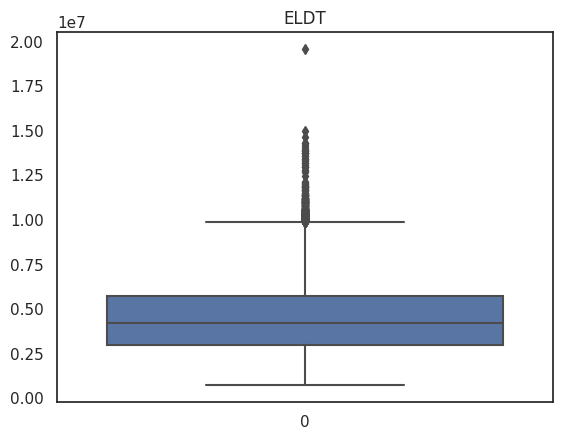

In [ ]:
# Boxplot do ELDT
# fig = px.box(BIMTRA_df_adjusted['eldt'], title='ELDT', labels={'value': 'ELDT'}, points='outliers')
# fig.update_traces(dict(marker=dict(size=7,color="darkslategrey"),line=dict(width=1, color="darkslategrey")))
# fig.show()
sns.boxplot(BIMTRA_df_adjusted['eldt'], showfliers=True)

plt.title('ELDT')

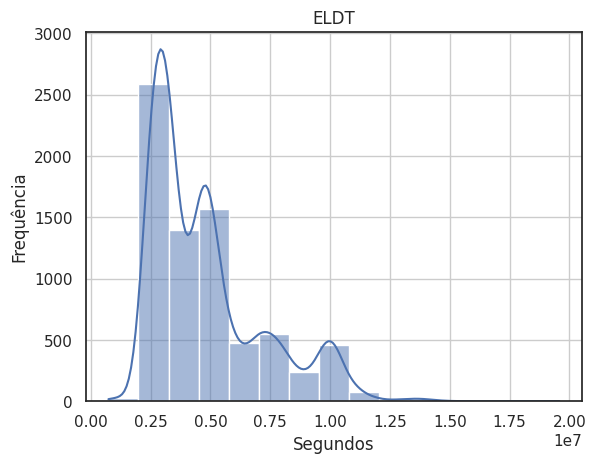

In [ ]:
sns.histplot(BIMTRA_df_adjusted['eldt'], bins=15, kde = True)

plt.xlabel('Segundos')
plt.ylabel('Frequência')
plt.title('ELDT')
plt.grid(True)

# Exiba o histograma
plt.show()

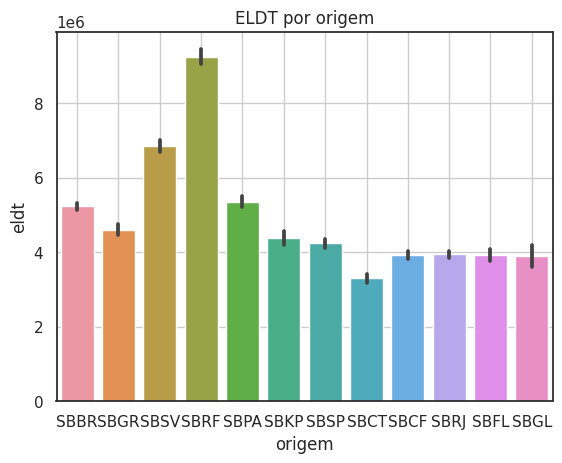

In [ ]:
sns.barplot(x=BIMTRA_df_adjusted['origem'], y=BIMTRA_df_adjusted['eldt'])

plt.title('ELDT por origem')
plt.grid(True)

plt.show()

In [ ]:
# Agrupar por origem e destino e calcular as estatísticas
impacto_aeroportos = BIMTRA_df_adjusted.groupby(['origem', 'destino']).agg({
    'flightid': 'count',              # Número total de voos
    'eldt': ['mean', 'min', 'max', 'std']  # Estatísticas de tempo de voo
}).reset_index()

# Renomear colunas para maior clareza
impacto_aeroportos.columns = ['Origem', 'Destino', 'Total_Voos', 'Tempo_Médio', 'Tempo_Mínimo', 'Tempo_Máximo', 'Desvio_Padrão']


display(impacto_aeroportos)

,Origem,Destino,Total_Voos,Tempo_Médio,Tempo_Mínimo,Tempo_Máximo,Desvio_Padrão
0,SBBR,SBCF,66,3.433106e+06,2340000.0,4951000.0,387052.814078
1,SBBR,SBCT,30,5.458567e+06,5057000.0,7148000.0,449829.828616
2,SBBR,SBFL,13,6.592077e+06,6053000.0,7581000.0,478541.440480
3,SBBR,SBGL,18,4.714778e+06,4467000.0,5693000.0,293727.275578
4,SBBR,SBGR,94,4.693394e+06,4279000.0,6104000.0,294600.375142
...,...,...,...,...,...,...,...
115,SBSV,SBKP,48,7.594562e+06,6887000.0,9608000.0,477485.519720
116,SBSV,SBPA,7,1.167800e+07,11077000.0,12466000.0,442867.173466
117,SBSV,SBRF,47,3.923851e+06,3403000.0,6515000.0,562920.952777
118,SBSV,SBRJ,59,6.970559e+06,6256000.0,10387000.0,792059.717167


# 3. Pré-processamento

In [ ]:
BIMTRA_df_adjusted

,flightid,origem,destino,dt_dep,n_aeronaves_500km,n_aeronaves_total,eldt,hora_ref,hora_esperas,esperas
0,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1.672537e+12,3,20,3446000.0,2023-01-01 01:00:00,2023-01-01 00:00:00,0.0
1,77146493eed6e8bd3b2c6bf664ab6463,SBGR,SBRF,1.672605e+12,44,75,9452000.0,2023-01-01 20:00:00,2023-01-01 19:00:00,0.0
2,f31820131a516c1ec5ee15f83069e85b,SBSV,SBGR,1.672584e+12,6,50,7974000.0,2023-01-01 14:00:00,2023-01-01 13:00:00,0.0
3,764519556a57671a468ddc3ca88bd53c,SBRF,SBRJ,1.672591e+12,5,67,10937000.0,2023-01-01 16:00:00,2023-01-01 15:00:00,0.0
4,9eb9087ec842a67d6269411ba200200c,SBPA,SBRJ,1.672602e+12,8,76,6665000.0,2023-01-01 19:00:00,2023-01-01 18:00:00,1.0
...,...,...,...,...,...,...,...,...,...,...
7423,d3119f952b9f14ccbf6ad1c09a488ea8,SBCT,SBGR,1.672540e+12,8,20,2235000.0,2023-01-01 02:00:00,2023-01-01 01:00:00,0.0
7424,4a4f48e2f236b5849724f1ca554aec9e,SBCT,SBGR,1.672575e+12,13,43,2156000.0,2023-01-01 12:00:00,2023-01-01 11:00:00,0.0
7425,8b8c934cda4bca3f1459850a85b80ce6,SBCF,SBGR,1.672604e+12,32,72,3334000.0,2023-01-01 20:00:00,2023-01-01 19:00:00,0.0
7426,abe3dd7a006dab7efcf419bd38521a0a,SBCF,SBGR,1.672614e+12,36,71,3912000.0,2023-01-01 22:00:00,2023-01-01 21:00:00,0.0


In [ ]:
BIMTRA_df_encoded = BIMTRA_df_adjusted.copy()

# # One hot encoding das chegadas

# origem = BIMTRA_df_adjusted['origem'].unique()
# origem = pd.get_dummies(origem, prefix='origem')
# BIMTRA_df_encoded = BIMTRA_df_adjusted.join(origem)

# # One hot encoding dos destinos

# destino = BIMTRA_df_encoded['destino'].unique()
# destino = pd.get_dummies(destino, prefix='destino')
# BIMTRA_df_encoded = BIMTRA_df_encoded.join(destino)
# BIMTRA_df_encoded

# BIMTRA_df_encoded.drop(['origem', 'destino'], axis=1, inplace=True)

# Organizando a ordem das colunas
l = list(BIMTRA_df_encoded.columns)
l.remove('eldt')
l.remove('flightid')
#l.remove('hora_tcp')
#l.remove('hora_tcr')
l.remove('hora_ref')
l.remove('hora_esperas')
''' l.remove('troca') '''
''' l.remove('troca_efetivada') '''
''' l.append('troca') '''
l.append('eldt')

BIMTRA_df_encoded = BIMTRA_df_encoded[l]

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
BIMTRA_df_encoded['origem'] = BIMTRA_df_encoded['origem'].astype('category')
BIMTRA_df_encoded['destino'] = BIMTRA_df_encoded['destino'].astype('category')

''' BIMTRA_df_encoded.rename(columns={'troca_efetivada': 'troca'}, inplace=True) '''


BIMTRA_df_encoded

,origem,destino,dt_dep,n_aeronaves_500km,n_aeronaves_total,esperas,eldt
0,SBBR,SBCF,1.672537e+12,3,20,0.0,3446000.0
1,SBGR,SBRF,1.672605e+12,44,75,0.0,9452000.0
2,SBSV,SBGR,1.672584e+12,6,50,0.0,7974000.0
3,SBRF,SBRJ,1.672591e+12,5,67,0.0,10937000.0
4,SBPA,SBRJ,1.672602e+12,8,76,1.0,6665000.0
...,...,...,...,...,...,...,...
7423,SBCT,SBGR,1.672540e+12,8,20,0.0,2235000.0
7424,SBCT,SBGR,1.672575e+12,13,43,0.0,2156000.0
7425,SBCF,SBGR,1.672604e+12,32,72,0.0,3334000.0
7426,SBCF,SBGR,1.672614e+12,36,71,0.0,3912000.0


# 4. Treinamento 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(BIMTRA_df_encoded.copy().drop('eldt', axis=1), BIMTRA_df_encoded['eldt'], test_size=0.2)

In [ ]:
reg = xg.XGBRegressor(objective= 'reg:squarederror', random_state=42, enable_categorical=True)

# Busca de melhores parâmetros 
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(reg, param_distributions=params, random_state=42, n_iter=100, cv=3, verbose=2, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.24959818254342153, max_depth=2, n_estimators=120, subsample=0.6624074561769746; total time=   0.9s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.24959818254342153, max_depth=2, n_estimators=120, subsample=0.6624074561769746; total time=   0.9s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.24959818254342153, max_depth=2, n_estimators=120, subsample=0.6624074561769746; total time=   0.9s
[CV] END colsample_bytree=0.7467983561008608, gamma=0.02904180608409973, learning_rate=0.28985284373248055, max_depth=5, n_estimators=139, subsample=0.8832290311184181; total time=   1.7s
[CV] END colsample_bytree=0.7467983561008608, gamma=0.02904180608409973, learning_rate=0.28985284373248055, max_depth=5, n_estimators=139, subsample=0.8832290311184181; total time=   1.7s


In [ ]:
# reg = xg.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7467983561008608, gamma=0.02904180608409973, learning_rate=0.28985284373248055, max_depth=5, n_estimators=139, subsample=0.8832290311184181, random_state=42, early_stopping_rounds=10, eval_set=[(X_test, y_test)], enable_categorical=True)
reg = xg.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.8045997961875188,
    gamma=0.04808827554571038,
    learning_rate=0.31215697934688114,
    max_depth=5,
    n_estimators=138,
    subsample=0.9746919954946938,
    random_state=42,
    enable_categorical=True,
)
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8045997961875188, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0.04808827554571038,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.31215697934688114,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=138, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## 4.1 Performance do modelo

In [ ]:
print("Performance do modelo nos dados de treino: ", str(round(reg.score(X_train, y_train) * 100, 2))+"%")
print("Performance do modelo nos dados de teste: ", str(round(reg.score(X_test, y_test) * 100, 2))+"%")

Performance do modelo nos dados de treino:  98.97%
Performance do modelo nos dados de teste:  94.61%


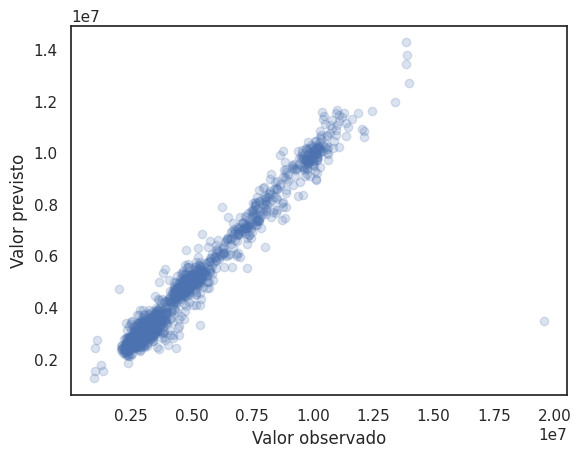

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

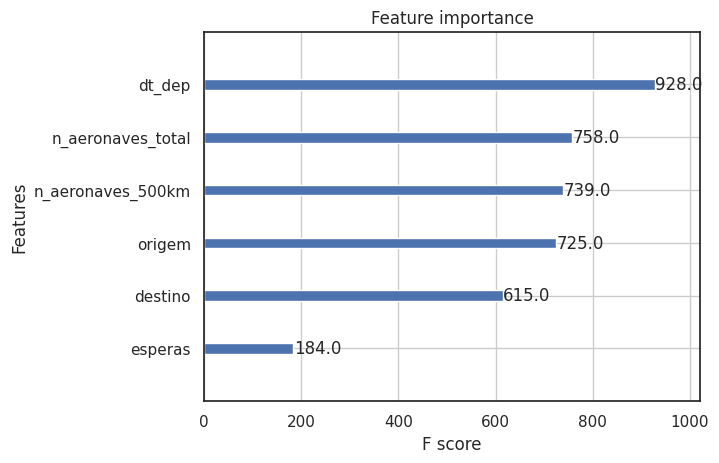

In [ ]:
# Previsão
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('Valor observado')
plt.ylabel('Valor previsto')
plt.show()

xg.plot_importance(reg)
# xg.plot_tree(reg, num_trees=reg.best_iteration)

# fig = px.scatter(x=y_test, y=y_pred)
# fig.update_xaxes(title="Valor observado")
# fig.update_yaxes(title="Valor previsto")

# # Add a title
# fig.update_layout(title="Valor observado vs. Valor previsto")


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Erro Quadrático Médio (MSE): ", mean_squared_error(y_test, y_pred))
print("Erro Absoluto Médio (MAE): ", mean_absolute_error(y_test, y_pred))
print("Raiz do Erro Quadrático Médio (RMSE) : ", np.sqrt(mean_squared_error(y_test, y_pred)))

print("R2: ", r2_score(y_test, y_pred))

Erro Quadrático Médio (MSE):  334809965154.0378
Erro Absoluto Médio (MAE):  290537.034159919
Raiz do Erro Quadrático Médio (RMSE) :  578627.656748308
R2:  0.946106016621758


# 5. Submissão

In [ ]:
# Csv de teste do Kaggle
idsc_test = pd.read_csv('idsc_test.csv')
idsc_test

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6f6d576aafbd90e308a848a060395e9a,SBPA,SBGR,2023-05-19 22:02:03.000,2023-05-19 22:00:00.000,MULTIPOINT ((-0.8891070333352145 -0.5128856751...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 21:00:00.000,0,SBGR,...,METAF SBGR 192300Z 11006KT 9000 FEW019 ...,SBGR,2023-05-19 22:00:00.000,METAR SBGR 192200Z 14003KT CAVOK 16/13 Q1021=,SBGR,2023-05-19 23:00:00.000,0,SBGR,NaN,NaN
96,20055ed6ecea5e916923081fc3b049f7,SBCF,SBKP,2023-05-31 19:54:04.000,2023-05-31 19:00:00.000,MULTIPOINT ((-0.8887839089364267 -0.5156303040...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 18:00:00.000,0,SBKP,...,METAF SBKP 312000Z 23006KT 9999 OVC022 ...,SBKP,2023-05-31 19:00:00.000,METAR SBKP 311900Z 24005KT 5000 2000S -RA BR B...,SBKP,2023-05-31 20:00:00.000,0,SBKP,2023-05-31 19:00:00.000,SBKP
97,c5e4e8d78906ae2b3218847cc9f045d9,SBSP,SBRJ,2023-05-20 15:16:05.000,2023-05-20 15:00:00.000,MULTIPOINT ((-0.8916331377478003 -0.5089690765...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-20 14:00:00.000,0,SBRJ,...,METAF SBRJ 201600Z 10003KT 9999 FEW033 ...,SBRJ,2023-05-20 15:00:00.000,METAR SBRJ 201500Z 34003KT 250V040 CAVOK 23/16...,SBRJ,2023-05-20 16:00:00.000,0,SBRJ,NaN,NaN
98,878ad3e9104c78f2945f6194c2d883ce,SBBR,SBSP,2023-05-31 11:31:02.000,2023-05-31 11:00:00.000,MULTIPOINT ((-0.8987280459174578 -0.5209708603...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 10:00:00.000,0,SBSP,...,METAF SBSP 311200Z 07006KT 6000 - RA OVC026 ...,SBSP,2023-05-31 11:00:00.000,METAR SBSP 311100Z 08006KT 020V120 4000 -RA BR...,SBSP,2023-05-31 12:00:00.000,0,SBSP,NaN,NaN


In [ ]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import MultiPoint

In [ ]:

s = gpd.GeoSeries(
    
)

# Create a new geodataframe of individual points
exploded_s = s.explode(index_parts=True)
exploded_s

In [ ]:
# Converte MULTIPOINT() para um uma lista de arrays
# coord_pairs = idsc_test['snapshot_radar'][0].replace("MULTIPOINT (", "").replace("))", "").split(", ")

n_aeronaves_idsc = []

# print(idsc_test['snapshot_radar'][0].replace("MULTIPOINT (", "").replace("))", "").split(", "))

# Para cada linha
for i in idsc_test['snapshot_radar'].index: 
    # Remove strings desnecesárias
    coord_pairs = idsc_test['snapshot_radar'][i].replace("MULTIPOINT (", "").replace("))", "").split(", ")
    n_aeronaves_idsc.append(len(coord_pairs))
    # for pair in coord_pairs:
    #     # Remove any remaining parentheses
    #     pair = pair.replace("(", "").replace(")", "")
    #     # Split the pair into individual values
    #     values = np.array(pair.split(), dtype=float)
    #     coordinates.append(np.array((float(values[0]), float(values[1]))))
    # full_list.append(coordinates)

# Cria uma lista com o número de aeronaves para cada linha do BIMTRA
n_aeronaves = [i.shape[0] - 1 for i in coords_raio] # Remove 1, pois é a própria aeronave decolando
n_aeronaves_total = [len(i) for i in CAT_list]

idsc_test['n_aeronaves'] = n_aeronaves_idsc

sns.histplot(n_aeronaves_idsc, bins=20, kde=True)
plt.show()

In [ ]:
idsc_test_encoded = idsc_test.copy()

# Organizando as colunas
l = list(idsc_test_encoded.columns)
l.remove('flightid')
idsc_test_encoded = idsc_test_encoded[l]

filtro = pd.Series(idsc_test_encoded.columns)
filtro = filtro[filtro.isin(BIMTRA_df_encoded.columns)]
idsc_test_encoded = idsc_test_encoded[filtro]

# Converte data e hora para o tipo milissegundos desde 1970
idsc_test_encoded['dt_dep'] = pd.to_datetime(idsc_test_encoded['dt_dep'], format='%Y-%m-%d %H:%M:%S.%f')
idsc_test_encoded['dt_dep'] = (idsc_test_encoded['dt_dep'].astype(int) / 10**6) #.astype('datetime64[ms]')

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
idsc_test_encoded['origem'] = idsc_test_encoded['origem'].astype('category')
idsc_test_encoded['destino'] = idsc_test_encoded['destino'].astype('category')

idsc_test_encoded

,origem,destino,dt_dep,esperas
0,SBKP,SBSV,1.685447e+12,0
1,SBFL,SBRJ,1.684485e+12,0
2,SBCF,SBGR,1.684756e+12,0
3,SBFL,SBSP,1.685376e+12,2
4,SBCF,SBKP,1.685053e+12,0
...,...,...,...,...
95,SBPA,SBGR,1.684534e+12,0
96,SBCF,SBKP,1.685563e+12,0
97,SBSP,SBRJ,1.684596e+12,0
98,SBBR,SBSP,1.685533e+12,0


In [ ]:
# Prediz os valores
y_pred = reg.predict(idsc_test_encoded)
data_in_seconds = y_pred / 1000.0

# Criar um DataFrame com a coluna de dados em segundos
y_pred = pd.DataFrame(data_in_seconds)

y_pred

ValueError: feature_names mismatch: ['origem', 'destino', 'dt_dep', 'n_aeronaves_500km', 'n_aeronaves_total', 'esperas'] ['origem', 'destino', 'dt_dep', 'esperas']
expected n_aeronaves_total, n_aeronaves_500km in input data

In [ ]:
sumbission = pd.DataFrame()
sumbission['ID'] = idsc_test['flightid']
sumbission['solution'] = y_pred

sumbission.to_csv('submission.csv', index=False)

In [ ]:
sumbission

,ID,solution
0,7945735584a3297121c4f5ae0de8ecd1,6871.642090
1,85cb958e8b9d583575cd9cb93e389226,3953.784912
2,2d4e8cd3947525a12ff16af520beefb9,3400.325928
3,24cf317a1494a016a018d9f5cd183639,3103.141113
4,370babaf32dc82a6a64bf5b71a3434ed,3333.703369
...,...,...
95,6f6d576aafbd90e308a848a060395e9a,4944.584473
96,20055ed6ecea5e916923081fc3b049f7,3333.703369
97,c5e4e8d78906ae2b3218847cc9f045d9,2448.214844
98,878ad3e9104c78f2945f6194c2d883ce,4973.890137


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4ef28bfa-f18c-417e-93b5-8e27cf9bc92e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>